<a href="https://colab.research.google.com/github/github0apurva/DrugReview/blob/master/DrugReview_co_next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING RELEVANT LIBRARIES**

In [2]:
import numpy as np
np.random.seed(27)
import time as tp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf

import joblib
from google.colab import files

from tensorflow.keras import regularizers , Input 
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, Flatten, concatenate, LSTM, Bidirectional, GRU
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **UPLOADING THE TRAIN & TEST DATA SAVED ON MY DRIVE**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!gsutil -m cp -r /content/drive/My\ Drive/Data/E.pickle /content/
!gsutil -m cp -r /content/drive/My\ Drive/Data/R.pickle /content/

Copying file:///content/drive/My Drive/Data/E.pickle...
/ [1/1 files][ 27.4 MiB/ 27.4 MiB] 100% Done                                    
Operation completed over 1 objects/27.4 MiB.                                     
Copying file:///content/drive/My Drive/Data/R.pickle...
-
Operation completed over 1 objects/86.6 MiB.                                     


In [0]:
seq_padded, train_aux, label3 = joblib.load('R.pickle')
seq_padded_test, test_aux ,label3_test = joblib.load('E.pickle')

In [9]:
print ( seq_padded.shape , train_aux.shape , label3.shape)
print ( seq_padded_test.shape , test_aux.shape , label3_test.shape)

(160398, 100) (160398, 25) (160398,)
(53471, 100) (53471, 25) (53471,)


# **UNDERSAMPLING: CLASS FREQUENCY BALANCE**

In [10]:
label3.value_counts()

3    96915
1    34848
2    28635
Name: rating_3, dtype: int64

In [11]:
train_comp = pd.concat( (label3.reset_index(drop = True), pd.DataFrame(seq_padded) , train_aux.reset_index(drop = True) ), axis = 1 )
train_comp.rating_3.value_counts()

3    96915
1    34848
2    28635
Name: rating_3, dtype: int64

In [12]:
train_comp1 = train_comp[ train_comp.rating_3 == 1 ].sample(train_comp.rating_3.value_counts().min())
train_comp2 = train_comp[ train_comp.rating_3 == 2 ].sample(train_comp.rating_3.value_counts().min())
train_comp3 = train_comp[ train_comp.rating_3 == 3 ].sample(train_comp.rating_3.value_counts().min())

train_comp = pd.concat( ( train_comp1 , train_comp2, train_comp3 ), axis = 0 )
train_comp.rating_3.value_counts()

3    28635
2    28635
1    28635
Name: rating_3, dtype: int64

In [0]:
label3_n = pd.Series( train_comp ['rating_3'] )
seq_padded_n = np.array ((  train_comp.iloc [: , 1: -25 ] ))
train_aux_n = train_comp.iloc [: , -25: ]
del train_comp , train_comp1 , train_comp2 , train_comp3

In [14]:
print ( seq_padded_n.shape , train_aux_n.shape , label3_n.shape)

(85905, 100) (85905, 25) (85905,)


# **MODEL PARAMETERS AND OBJECT**

In [0]:

class Model_build:

    def __init__ (self, typea, train_data, test_data, opti_type  ):
        self.typea = typea
        self.trainx , self.trainy = train_data
        self.testx , self.testy = test_data
        self.opti_type = opti_type

    def find_lr (self, epochs = 100,  start_lr = 1e-5 , moment = 0.9 , met = 'SparseCategoricalCrossentropy' ) :
      self.epochs = epochs
      self.start_lr = start_lr
      self.moment = moment
      self.met = met
      epoch_div =  int( - epochs /  np.log10(start_lr) )
      # creating a time variable for calculating the total time taken to run the training and validation.
      t = tp.time()
      # defining the LR Schedule, experimenting with different learning rates
      lr_schedule = LearningRateScheduler(lambda epoch: start_lr* 10 ** (epoch / epoch_div ))
      # defining the optimizer
      if self.opti_type == 'adam':
          opti = Adam( lr = start_lr )
      else:
          opti = SGD( lr = start_lr , momentum = moment)
      # Compiling the model
      if self.typea == 'class':
          model.compile( loss = 'sparse_categorical_crossentropy', optimizer = opti , metrics = [self.met] )
      else:
          model.compile( loss = 'mean_absolute_error', optimizer = opti, metrics = [self.met])
      # Fitting the training data with simultaneously validating
      self.find_hist = model.fit( self.trainx , self.trainy -1  , epochs = epochs , callbacks = [lr_schedule], verbose = 0, batch_size = param_mod['training_size'] )
      t1 = tp.time() - t
      print ( int ( t1 / 60 ) , " minutes taken" )
      return self.find_hist

    def plot_find_lr (self, uplim = 1 ):
      plt.semilogx(self.find_hist.history["lr"] , self.find_hist.history["loss"] )
      plt.axis([self.start_lr , self.find_hist.history["lr"][-1], 0 , uplim])
      plt.title('loss across epoch ')
      return

    def fixed_lr ( self, epochs = 20, sel_lr = 1e-6, moment = 0.9, met = ' ', beta_1 = 0.9, beta_2 = 0.999, epsilon=1e-07  ):
      self.met_fix = met
      if met == ' ':
          self.met_fix = self.met
      t = tp.time()
      if self.opti_type == 'adam':
          opti = Adam( lr = sel_lr , beta_1 = beta_1 , beta_2 = beta_2 , epsilon = epsilon  )
      else:
          opti = SGD( lr = sel_lr , momentum = moment)
      # Compiling the model
      if self.typea == 'class':
          model.compile( loss = 'sparse_categorical_crossentropy', optimizer = opti , metrics = [self.met_fix] )
      else:
          model.compile( loss = 'mean_absolute_error', optimizer = opti , metrics = [self.met_fix] )
      # Fitting the training data with simultaneously validating
      self.hist = model.fit(self.trainx , self.trainy -1  , epochs = epochs , validation_data = ( self.testx, self.testy -1 ) , verbose = 1, batch_size = param_mod['training_size'] )
      t1 = tp.time() - t
      print ( int ( t1 / 60 ) , " minutes taken" )
      return self.hist

    def plot_fixed_lr (self, uplim = 1 ) :
        met_use = self.met_fix
        if self.met_fix == 'accuracy' and self.typea == 'reg':
            met_use = 'acc'
        plt.plot(np.array(self.hist.epoch)+1, self.hist.history[met_use], label = met_use )
        plt.plot(np.array(self.hist.epoch)+1, self.hist.history['val_'+met_use], label = "val_"+ met_use )
        plt.xlabel('epoch')
        plt.axis([1 , self.hist.epoch[-1]+1 , 0 , uplim ])
        plt.title(met_use +' across epoch ')
        plt.legend()
        plt.show()



In [0]:
param_mod = {
'input_shape' : seq_padded.shape[1],
'aux_shape' : train_aux.shape[1],
'embedding_dim' : 16 ,
'training_size' : 1024,
'vocab_size' : 5000 ,
'max_length' : 100 ,
'GLOVE_DIR' : 'C:/Users/Apurva/Desktop/CaseStudy',
'GLOVE_FILE' : 'glove.840B.300d.txt'
}

# **MODEL STRUCTURE AND BUILDING**

In [31]:
tf.keras.backend.clear_session()

prim_input = Input      ( shape =( param_mod['input_shape'] ) , name='prim')
aux_input = Input       (shape=(param_mod['aux_shape'],), name='aux')
feat_embed = Embedding  (param_mod['vocab_size'] ,param_mod['embedding_dim'] ,  input_length = param_mod['input_shape'] )(prim_input)
feat_flat = Flatten     ()(feat_embed)
feat_con = concatenate  ([feat_flat,aux_input])
feat_sftm = Dense       (3,activation = 'softmax')(feat_con)

model = tf.keras.Model(inputs=[prim_input, aux_input], outputs=[feat_sftm])
model.summary()
 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prim (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 16)      80000       prim[0][0]                       
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1600)         0           embedding[0][0]                  
__________________________________________________________________________________________________
aux (InputLayer)                [(None, 25)]         0                                            
______________________________________________________________________________________________

In [32]:
model_build = Model_build ( typea = 'class' , train_data = ((seq_padded,train_aux),label3)   , test_data = ((seq_padded_test,test_aux),label3_test), opti_type = 'adam' )
# finding the best learning rate
f_hist = model_build.find_lr ( epochs = 10 , start_lr = 1e-5, met = 'accuracy')

0  minutes taken


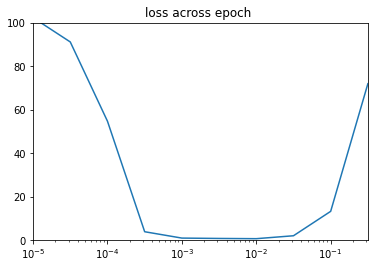

In [33]:
# plotting the loss against learning rates
model_build.plot_find_lr (100)

In [34]:
# Using the finalized learning rate
hist = model_build.fixed_lr( epochs = 5 , sel_lr = 1*1e-2 )

Epoch 1/5
157/157 [==============================] - 3s 20ms/step - loss: 21.9424 - accuracy: 0.7190 - val_loss: 21.2334 - val_accuracy: 0.6714
Epoch 2/5
157/157 [==============================] - 3s 20ms/step - loss: 10.2645 - accuracy: 0.7527 - val_loss: 14.2542 - val_accuracy: 0.6471
Epoch 3/5
157/157 [==============================] - 3s 21ms/step - loss: 5.8089 - accuracy: 0.7543 - val_loss: 10.9211 - val_accuracy: 0.6270
Epoch 4/5
157/157 [==============================] - 3s 21ms/step - loss: 3.6956 - accuracy: 0.7464 - val_loss: 9.5950 - val_accuracy: 0.5985
Epoch 5/5
157/157 [==============================] - 3s 20ms/step - loss: 2.6878 - accuracy: 0.7393 - val_loss: 8.2405 - val_accuracy: 0.6135
0  minutes taken


In [29]:
hist.history

{'accuracy': [0.7503647208213806,
  0.7475218176841736,
  0.7417424321174622,
  0.7372785210609436,
  0.7374094724655151],
 'loss': [6.337673187255859,
  3.647199869155884,
  2.4880318641662598,
  2.010040760040283,
  1.6041380167007446],
 'val_accuracy': [0.5842606425285339,
  0.5793607831001282,
  0.6109105944633484,
  0.5773409605026245,
  0.5970712900161743],
 'val_loss': [11.210371971130371,
  8.825387001037598,
  7.330904483795166,
  7.290607452392578,
  6.991600513458252]}

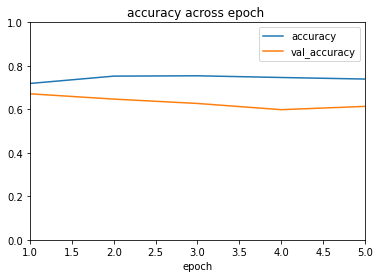

In [35]:
# plotting the mae across all epochs
model_build.plot_fixed_lr()

In [37]:
train_pred = np.argmax( model.predict ( ( seq_padded , train_aux )), axis=1) +1
pd.crosstab(train_pred, label3)

rating_3,1,2,3
row_0,,,
1,27750,7710,6742
2,996,5701,2119
3,6102,15224,88054


In [38]:
train_pred = np.argmax( model.predict ( ( seq_padded_test , test_aux )), axis=1) +1
pd.crosstab(train_pred, label3_test )

rating_3,1,2,3
row_0,,,
1,7054,2962,3357
2,2737,2194,5261
3,1995,4354,23557
